In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

# implement the confusion matrix in the first example

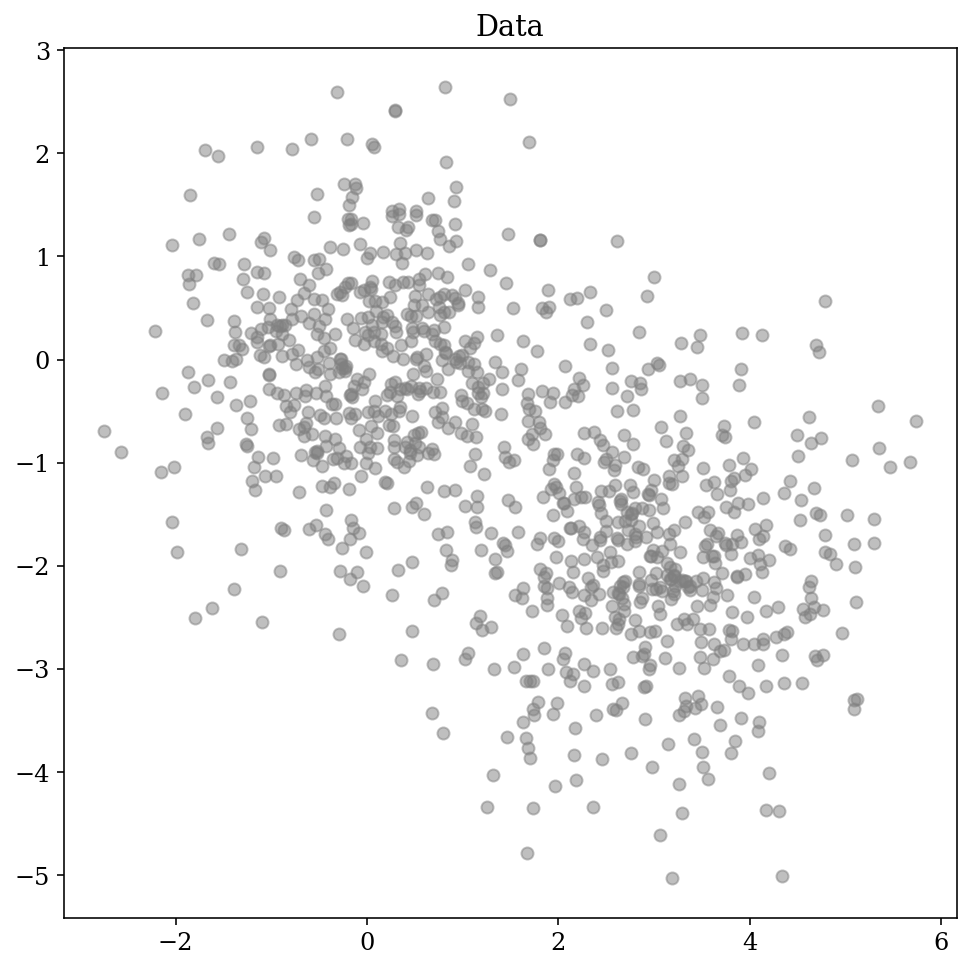

In [2]:
# Generate mock data


mode1= np.random.normal(size=(500,2))
mode2= np.random.normal(loc=[3.0,-2.0], size=(500,2))

#X = np.random.normal(size=(1000,2)) #1000 points in 2D
X = np.concatenate([mode1,mode2]) # 1000  points in 2D

plt.title('Data')
plt.scatter(X[:,0],X[:,1],color='gray',alpha=0.5)
plt.show()

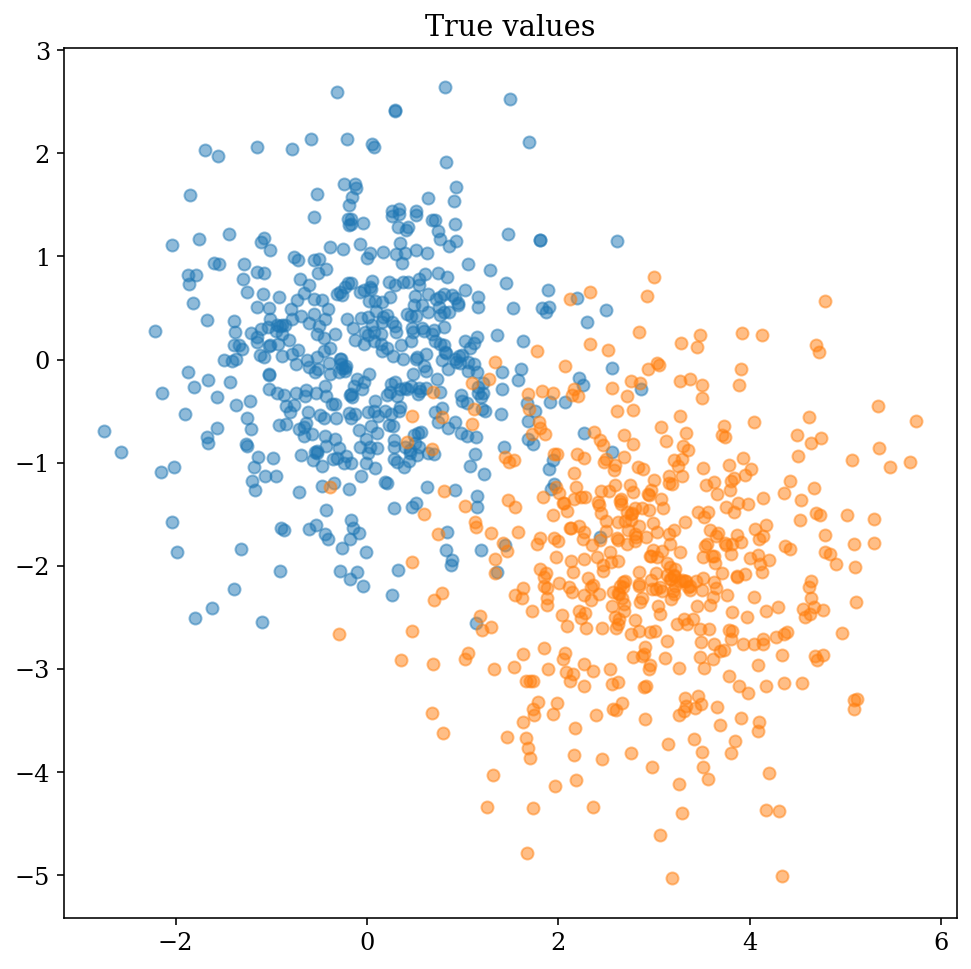

In [3]:
plt.title('True values')
plt.scatter(mode1[:,0],mode1[:,1],color='C0',alpha=0.5)
plt.scatter(mode2[:,0],mode2[:,1],color='C1',alpha=0.5)
plt.show()

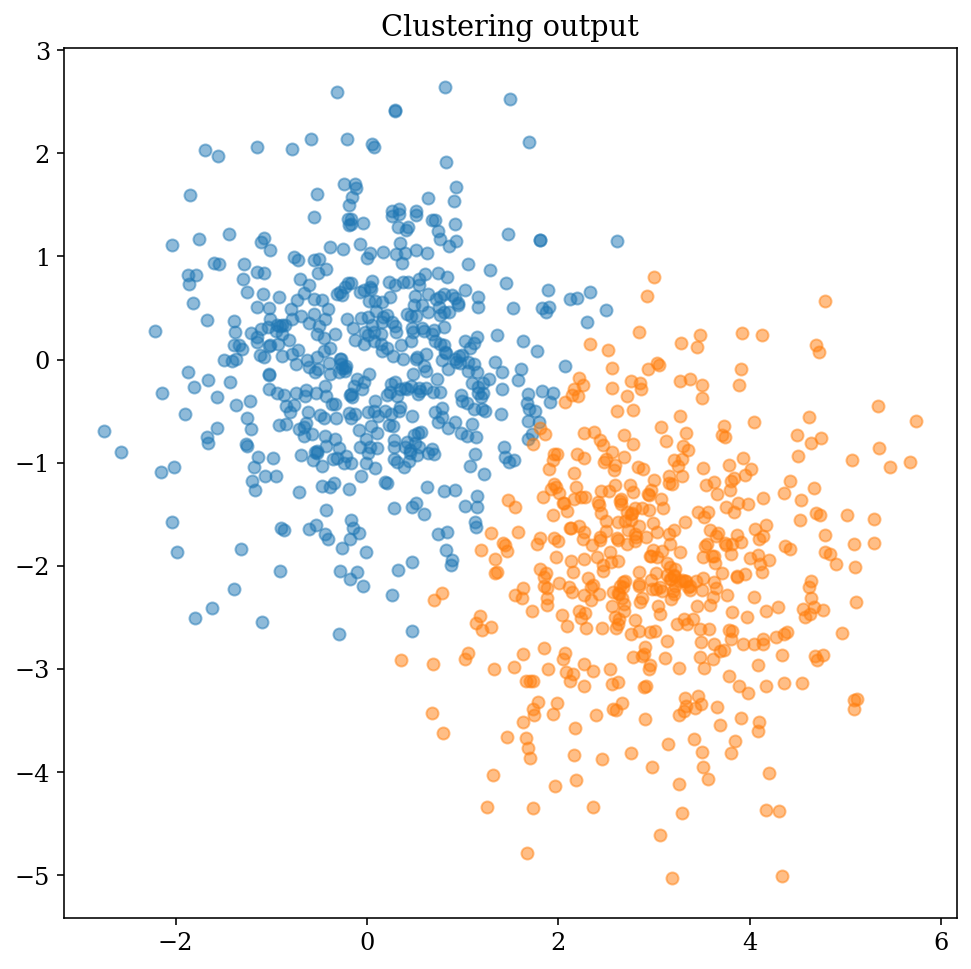

In [4]:
clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

# To get some information on these try:
# KMeans?
# help(clf)
plt.title('Clustering output')
plt.show()

In [5]:
from sklearn.metrics import confusion_matrix

labels_true = np.zeros(len(X))
labels_true[int(len(labels_true) / 2):] = 1

if colors[0]=='C1':
    labels_true = labels_true[::-1]

cm = confusion_matrix(labels_true, labels)
print(cm)

[[483  17]
 [ 33 467]]


# GRB playground

In [6]:
# Download file -- uncomment to download
#r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
#with open("Summary_table.txt", 'wb') as f:
#    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [7]:
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [8]:
print(data.shape)

(15, 7819)


## ra-dec

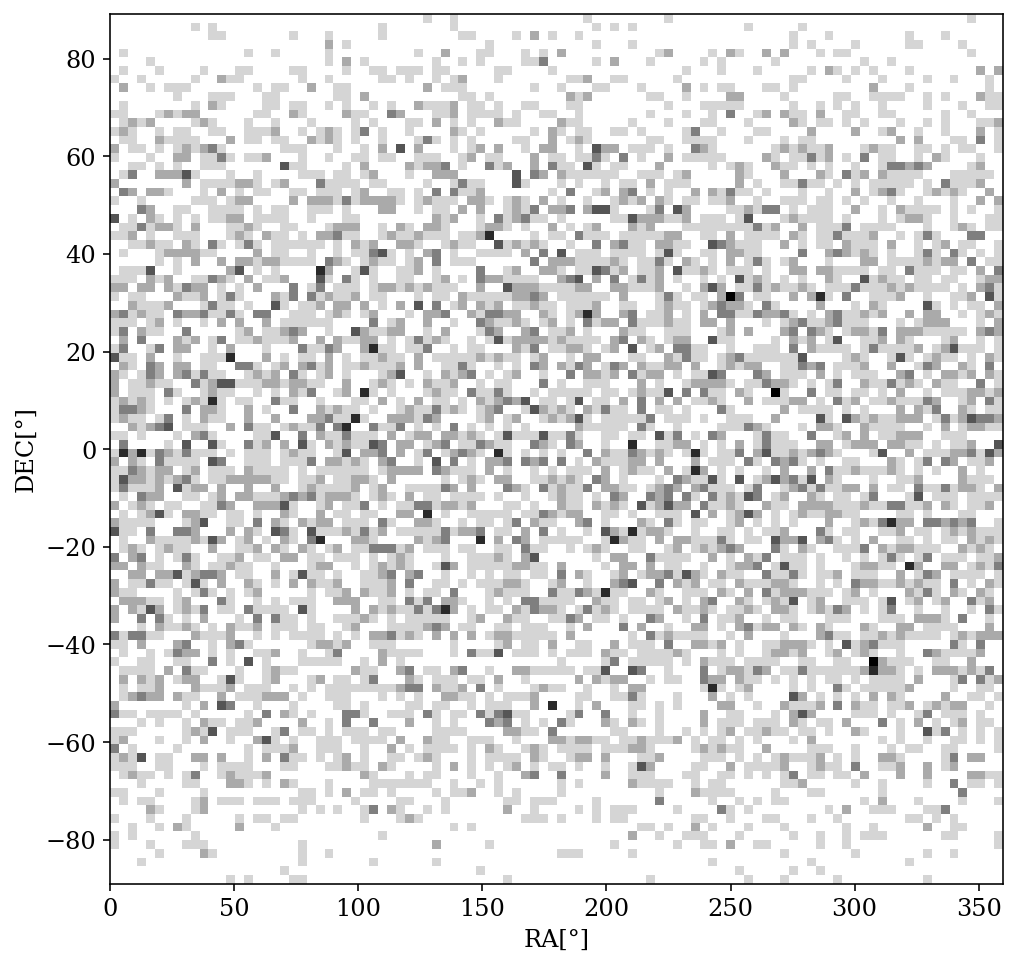

In [9]:
ra = data[3].astype(float)
dec = data[4].astype(float)
#plt.scatter(ra, dec, c = 'k', alpha = 0.3)
plt.hist2d(ra, dec, bins = 100, cmap = 'binary')
plt.xlabel('RA[°]')
plt.ylabel('DEC[°]')
plt.show()

no clusters? check with a uniform distribution

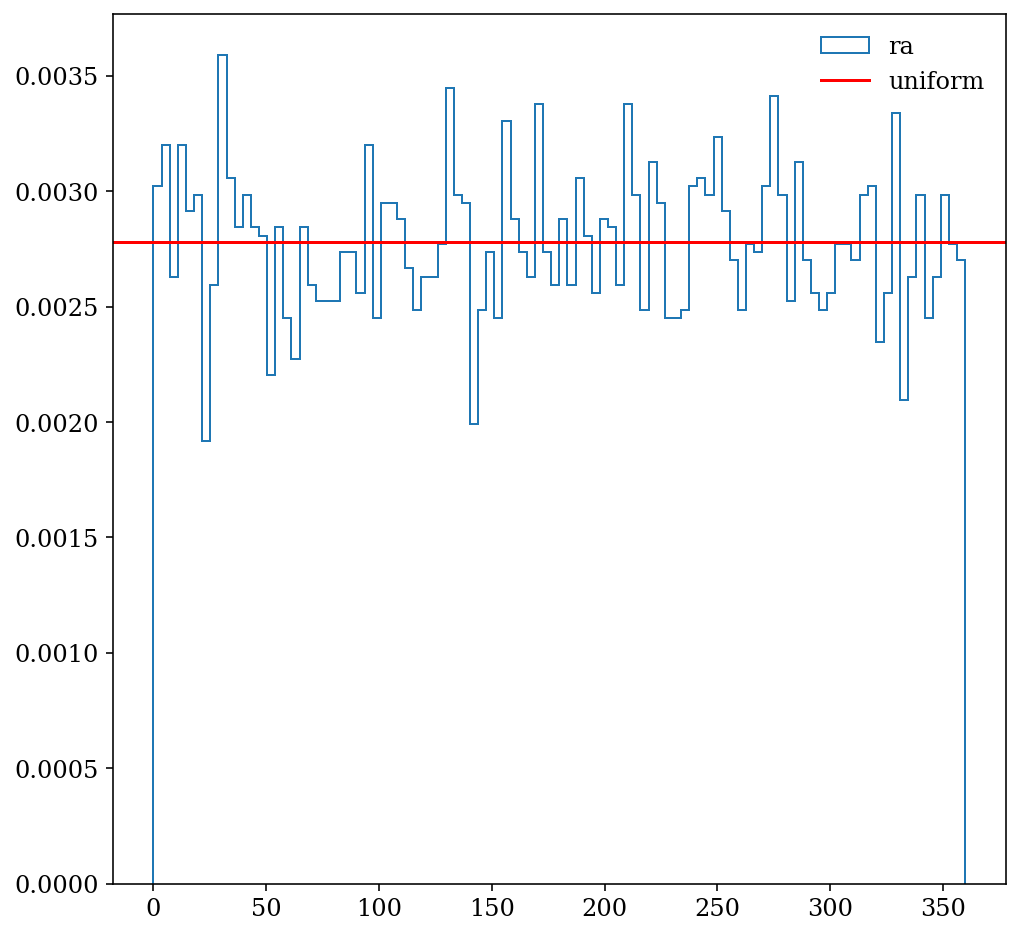

In [10]:
plt.hist(ra, bins = 100, density = True, histtype = 'step', label ='ra')
plt.axhline(1/(ra.max() - ra.min()), c = 'r', label = 'uniform')
plt.legend(frameon = False)
plt.show()

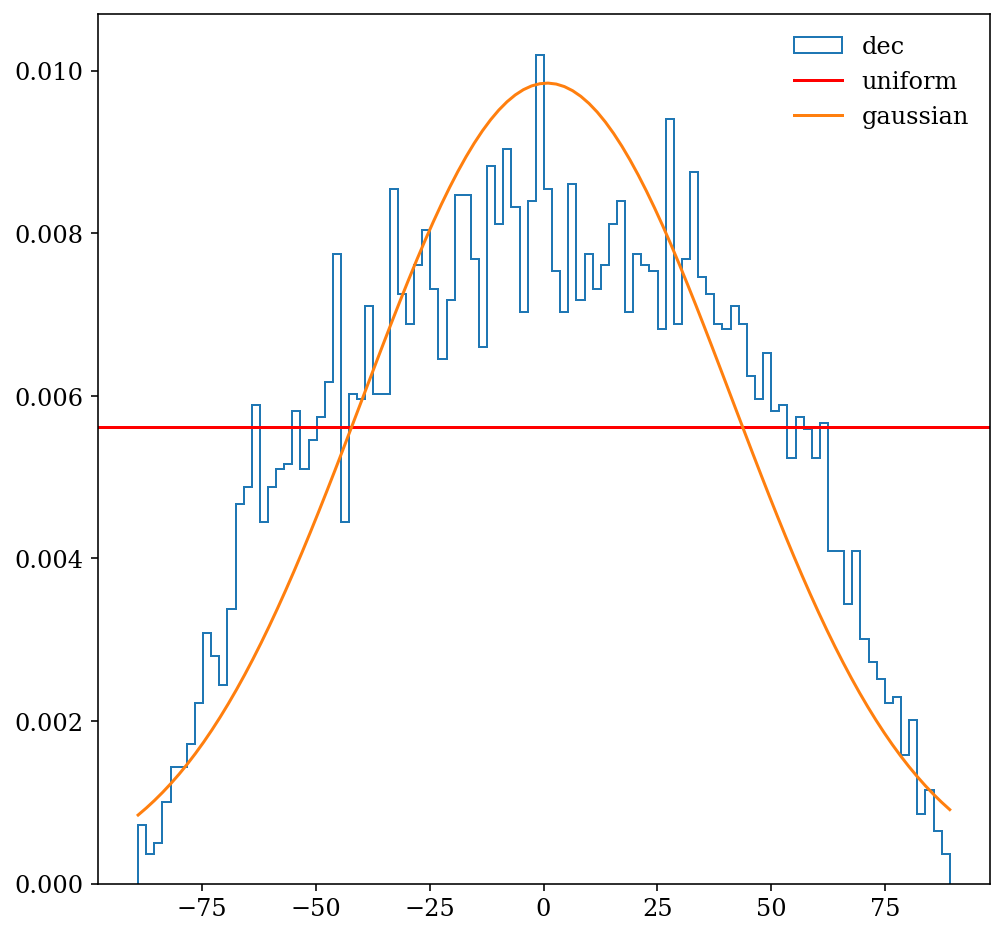

In [11]:
plt.hist(dec, bins = 100, density = True, histtype = 'step', label ='dec')
mu, scale = norm.fit(dec)
gauss = norm(mu, scale)

grid = np.linspace(dec.min(), dec.max(), 100)

plt.axhline(1/(dec.max() - dec.min()), c = 'r', label = 'uniform')
plt.plot(grid, gauss.pdf(grid), label = 'gaussian')

plt.legend(frameon = False)
plt.show()

uniform in right ascension, neither uniform nor gaussian in declination

## T90-fluence

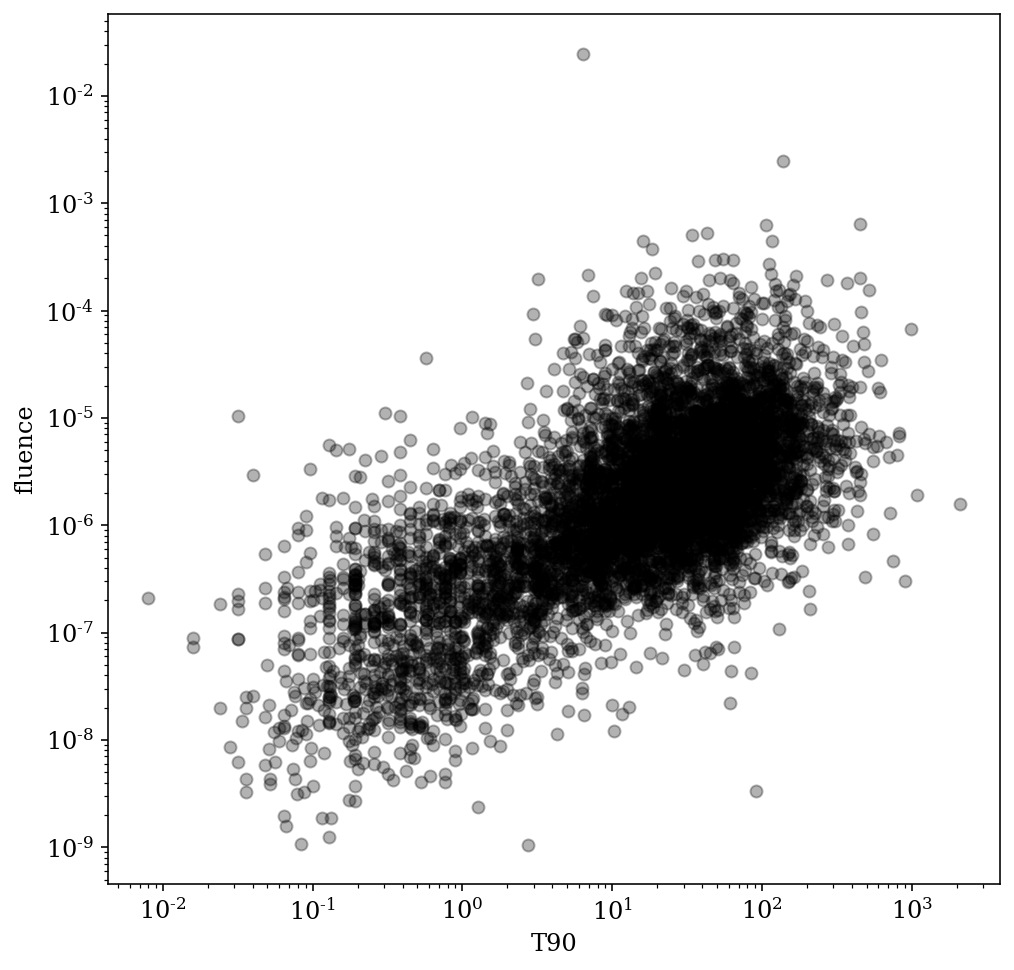

In [12]:
T90 = data[6].astype(float)
fluence = data[9].astype(float)

mask = (T90 > 0) & (fluence > 0)
#mask = (T90 > -999) & (fluence > -999)

plt.scatter(T90[mask], fluence[mask], c = 'k', alpha = 0.3)

plt.xlabel('T90')
plt.ylabel('fluence')
plt.loglog()
plt.show()

### check for clusters:
short and long GRB? Try with 2 clusters:

In [13]:
# K means with 2 clusters
n_clusters = 2
clf = KMeans(n_clusters = n_clusters)

X = np.vstack([np.log10(T90[mask]), np.log10(fluence[mask])]).T #right shape for sklearn
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X)

centers

array([[ 1.52962797, -5.4815052 ],
       [ 0.04974784, -6.75910336]])

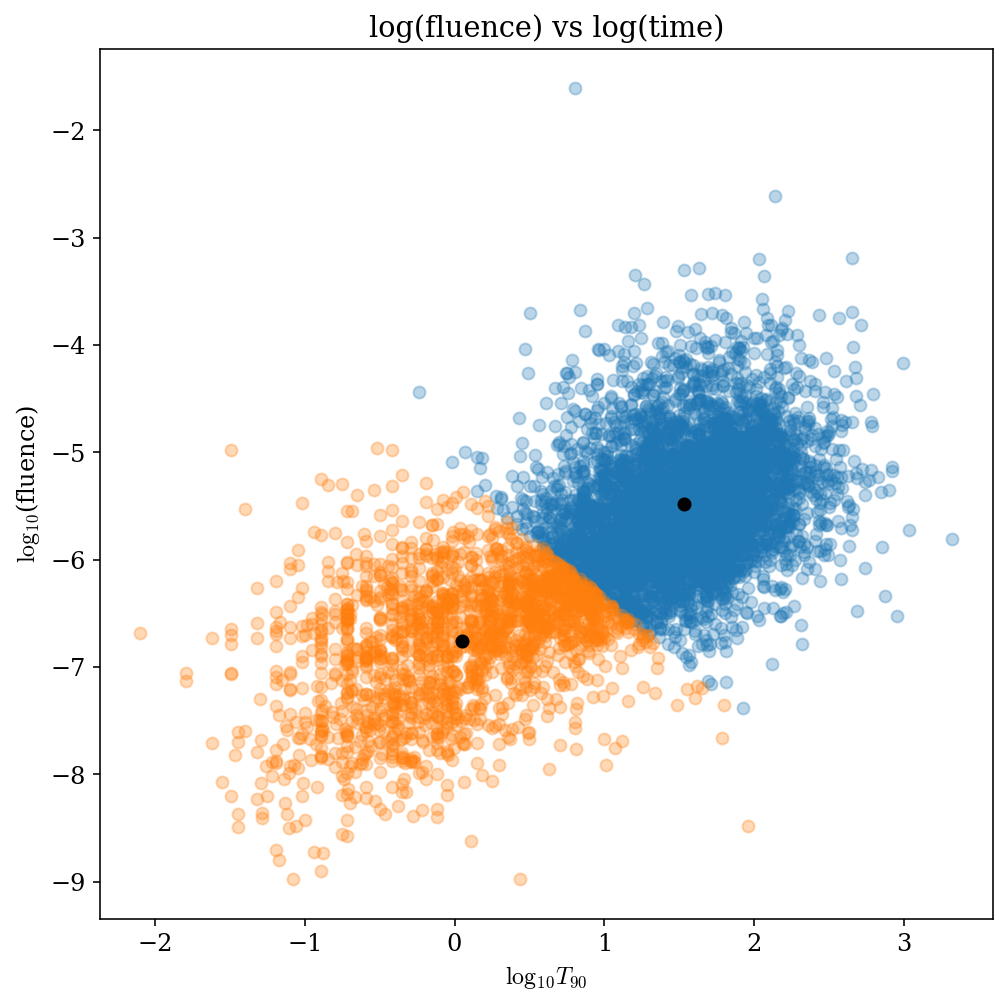

In [14]:
plt.figure()
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], alpha = 0.3)
plt.scatter(centers[:, 0], centers[:, 1], c='k')

plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$(fluence)')

#plt.loglog()
plt.title('log(fluence) vs log(time)')
plt.show()

does Mean-shift give the same result?

In [15]:
from astroML.utils.decorators import pickle_results

@pickle_results('bandwidth.pkl') #since it takes a while
def compute_bw(X):
    return estimate_bandwidth(X)

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

bandwidth = compute_bw(X)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(X)

@pickle_results: using precomputed results from 'bandwidth.pkl'


MeanShift(bandwidth=0.9188539247158468, bin_seeding=True, cluster_all=False)

In [17]:
labels_unique = np.unique(ms.labels_)
labels = ms.predict(X)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print("number of estimated clusters :", n_clusters)

#centers = scaler.inverse_transform(ms.cluster_centers_)
centers = ms.cluster_centers_

[-1  0  1]
number of estimated clusters : 2


In [18]:
centers

array([[ 1.4641514 , -5.62249849],
       [ 0.80617997, -1.60899428]])

In [19]:
len(labels[labels == 0])

6703

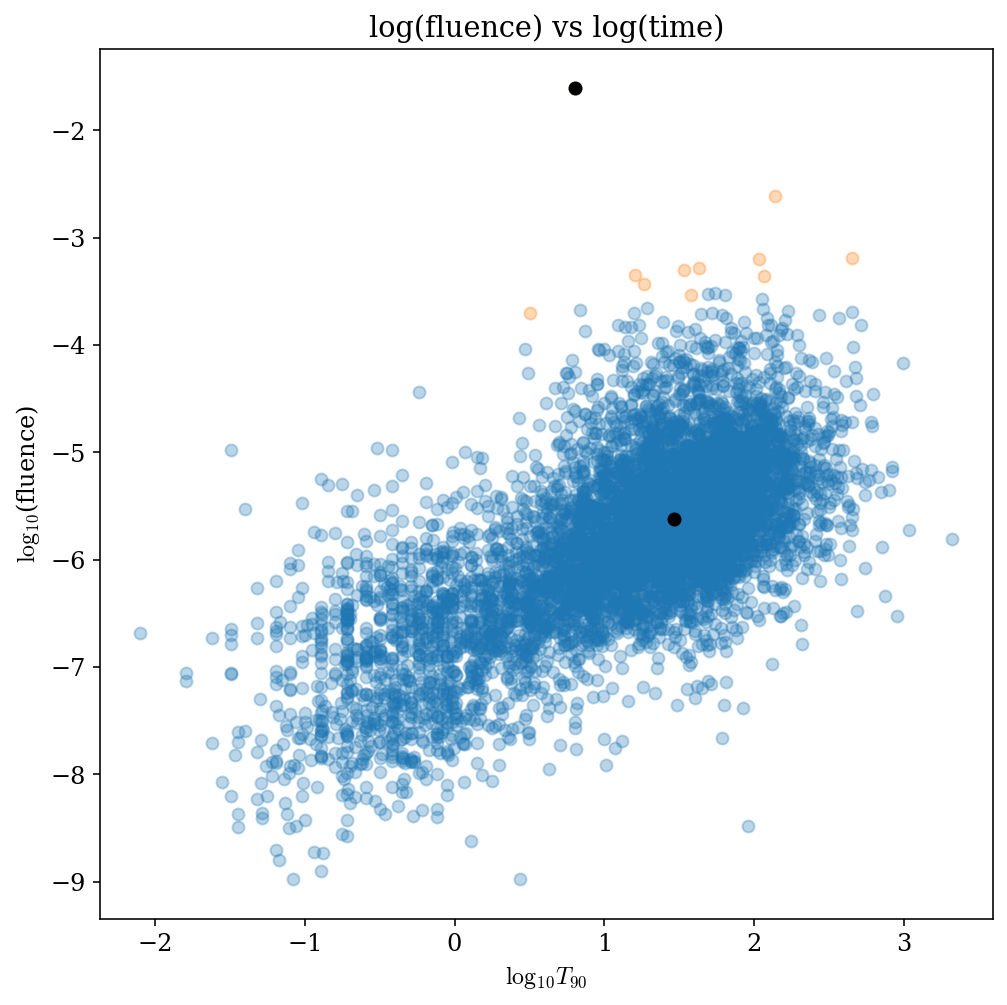

In [20]:
plt.figure()
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], alpha = 0.3)
plt.scatter(centers[:, 0], centers[:, 1], c='k')

plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$(fluence)')

#plt.loglog()
plt.title('log(fluence) vs log(time)')
plt.show()

?

## T90  
check the presence of the two populations using only $T_{90}$.

In [21]:
T90_masked = T90[T90 > -1]

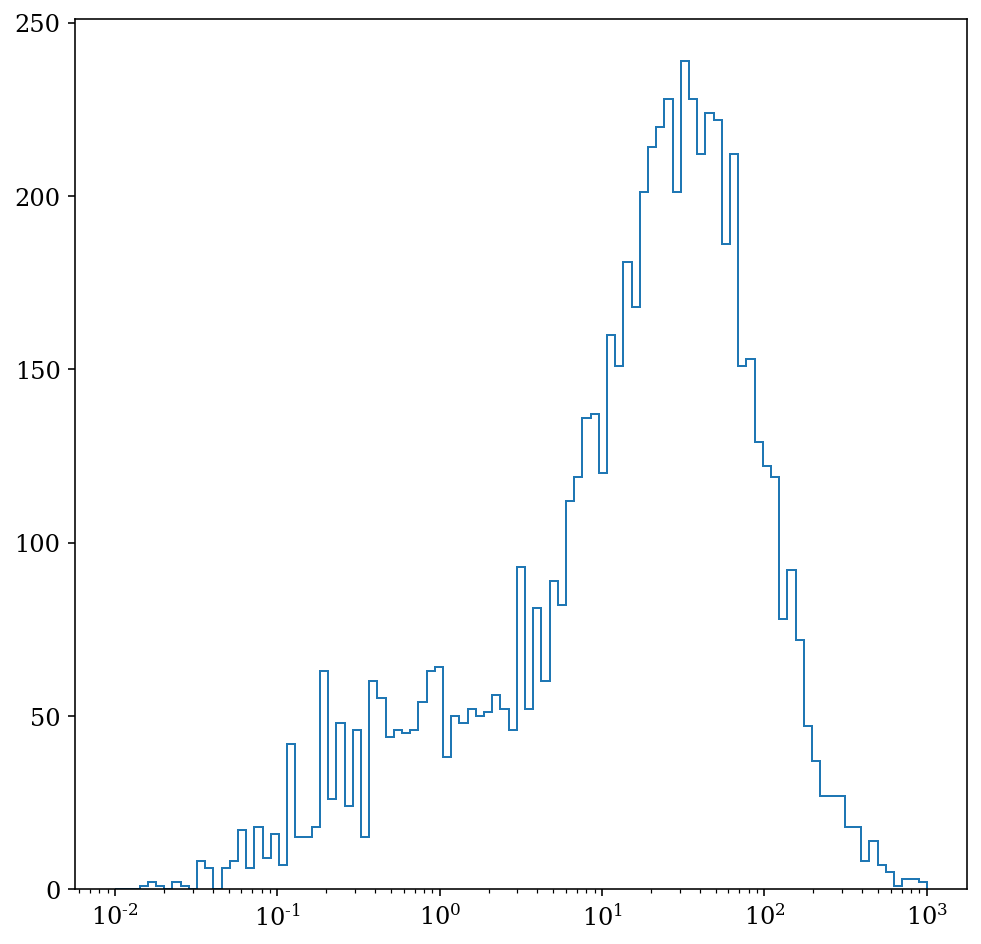

In [22]:
#histogram
plt.hist(T90_masked, bins = np.logspace(-2, 3, 100), histtype='step')
plt.semilogx()
plt.show()

In [23]:
#kde with cross validation
from sklearn.model_selection import GridSearchCV

logT90 = np.log10(T90_masked)[:, np.newaxis]

bwrange=np.linspace(0.01,1,10)
K = 3 # Do K-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) 
grid.fit(logT90) 
bw_opt = grid.best_params_['bandwidth']

kde = KernelDensity(kernel='gaussian', bandwidth=bw_opt).fit(logT90)

In [24]:
print(bw_opt)

0.12


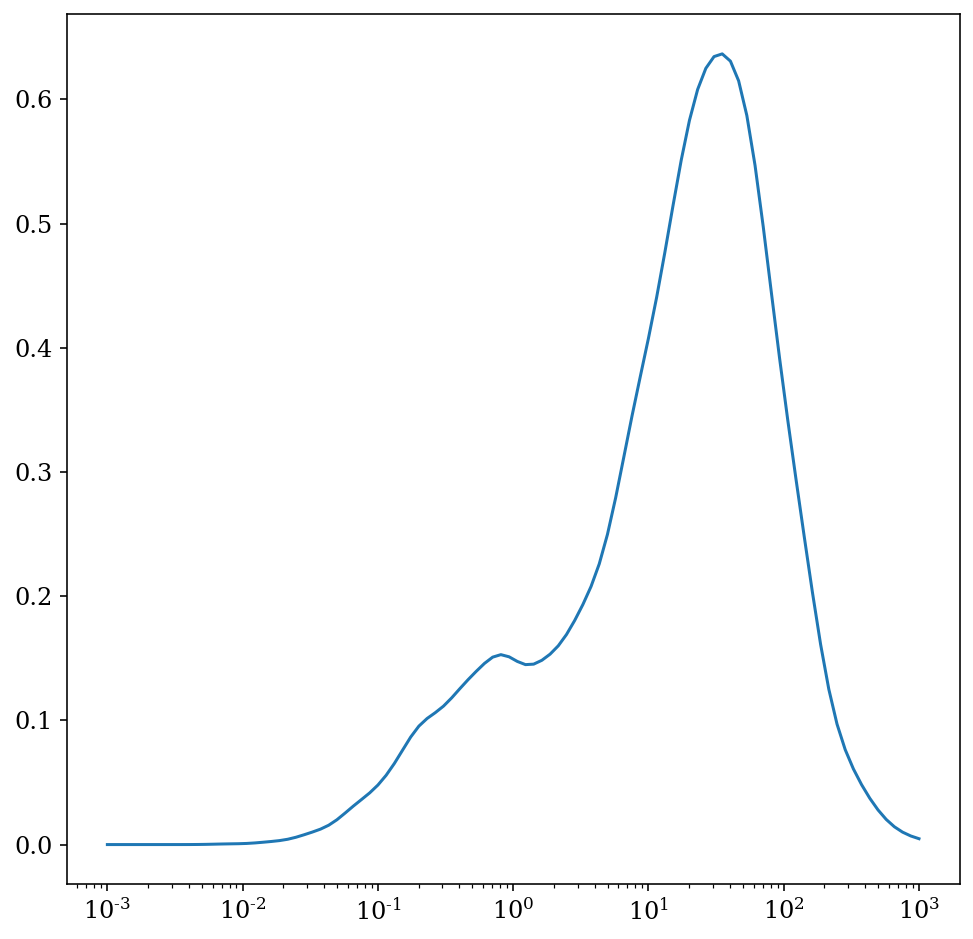

In [25]:
xgrid = np.logspace(-3, 3, 100)
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])))
plt.semilogx()
plt.show()

In [26]:
clf.fit(logT90)

KMeans(n_clusters=2)

In [27]:
T90_centers = 10**clf.cluster_centers_[:,0]
T90_labels = clf.predict(logT90)

if T90_centers[0] > T90_centers[1]:
    T90_centers = T90_centers[::-1]
    T90_labels = np.array(~np.array(T90_labels,dtype='bool'),dtype='int')
print('the centers are at T90 = %.2f s and T90 = %.2f s' % (T90_centers[0], T90_centers[1]))

the centers are at T90 = 0.91 s and T90 = 33.79 s


In [28]:
separation = 10**(np.mean([max(logT90[T90_labels == 0]), min(logT90[T90_labels == 1])]) )

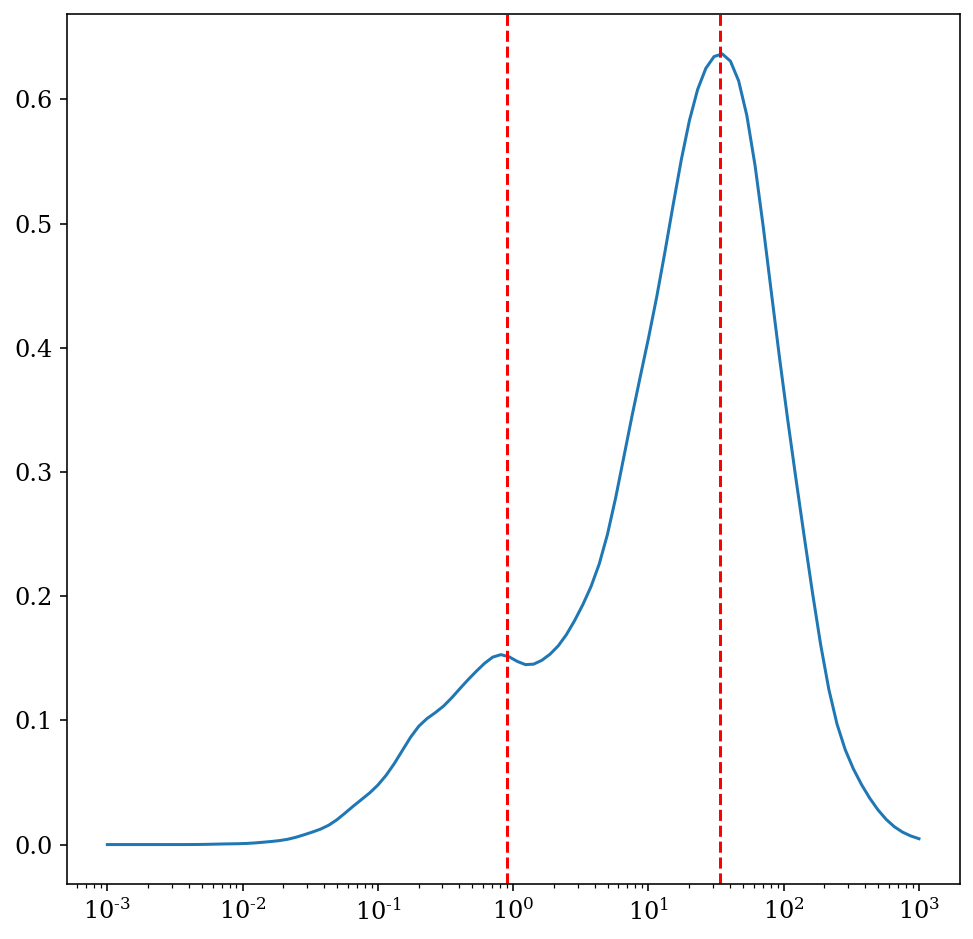

In [29]:
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])))
for cen in T90_centers:
    plt.axvline(cen, c = 'r', ls = '--')
plt.semilogx()
plt.show()

In [30]:
#gaussian mixture
gm = GaussianMixture(2).fit(logT90)

means = 10**gm.means_[:,0]

if means[0] > means[1]:
    means = means[::-1]

In [31]:
means

array([ 0.93366091, 31.23055047])

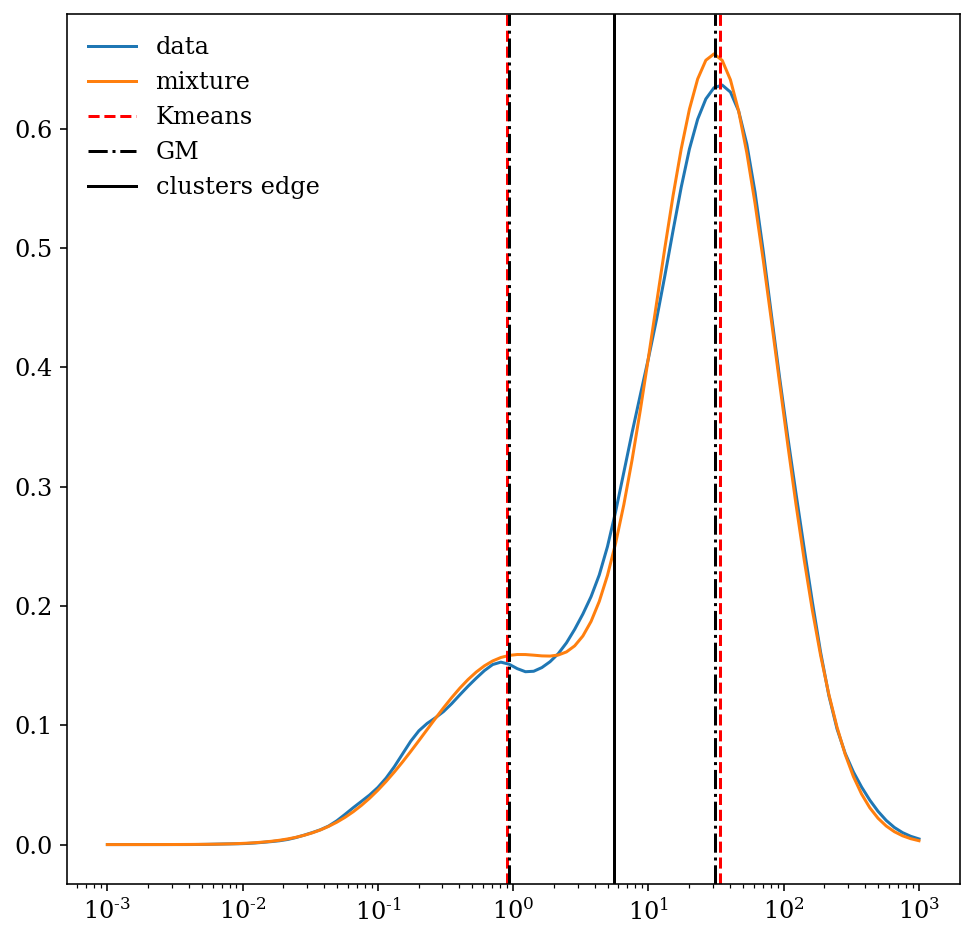

In [32]:
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])), label = 'data')
plt.plot(xgrid, np.exp(gm.score_samples(np.log10(xgrid)[:, np.newaxis])), label = 'mixture')

i=0

for cen, mean in zip(T90_centers, means):

    if i == 0:
        plt.axvline(cen, c = 'r', ls = '--', label = 'Kmeans')
        plt.axvline(mean, c = 'k', ls = '-.', label = 'GM')
    if i == 1:
        plt.axvline(cen, c = 'r', ls = '--')
        plt.axvline(mean, c = 'k', ls = '-.')
    i=1
    
        
plt.axvline(separation, c = 'k', ls = '-', label = 'clusters edge')
    
plt.semilogx()
plt.legend(frameon = False)
plt.show()

clustering and gaussian mixture give similar outcomes.

## redshift

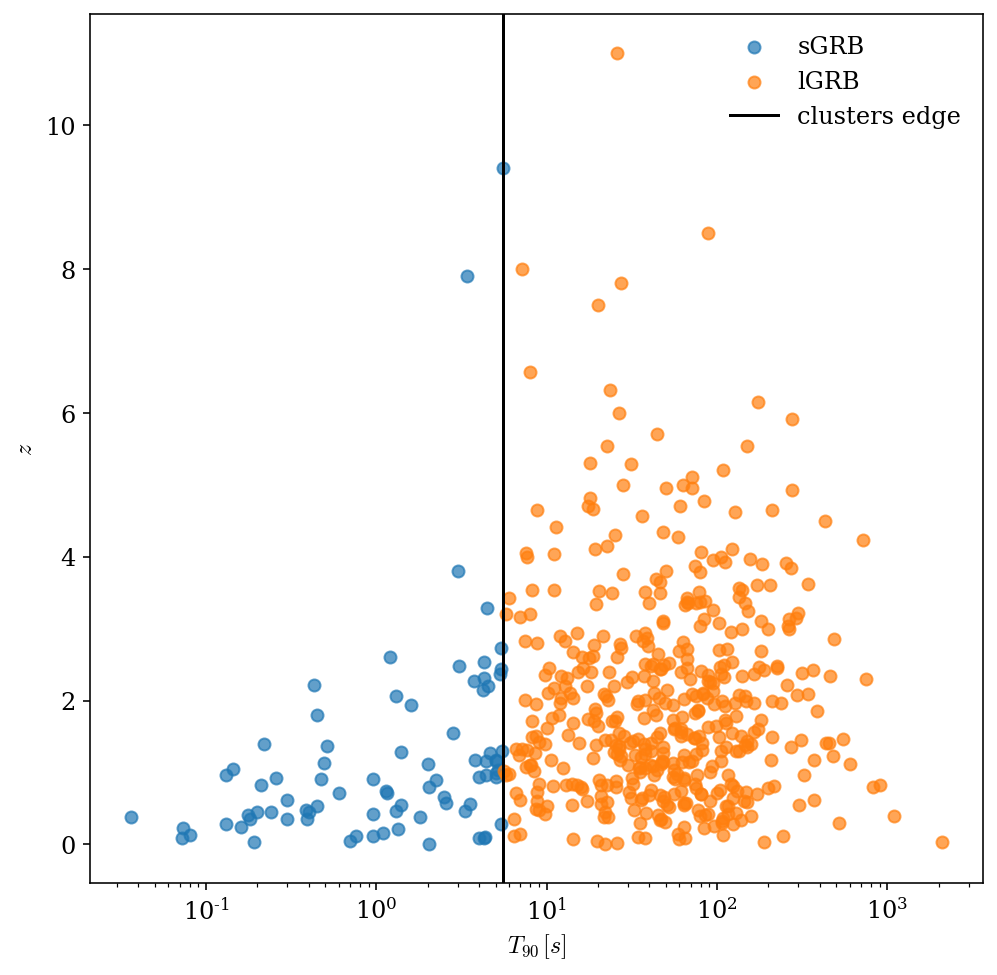

In [33]:
z = data[11].astype(float)

mask = (T90 > 0) & (z > 0)

plt.scatter(T90[mask & (T90 < separation)], z[mask & (T90 < separation)], c = 'C0', alpha = 0.7, label='sGRB')
plt.scatter(T90[mask & (T90 > separation)], z[mask & (T90 > separation)], c = 'C1', alpha = 0.7, label='lGRB')

plt.axvline(separation, c='k', label = 'clusters edge')

plt.xlabel(r'$T_{90}\, [s]$')
plt.ylabel(r'$z$')
plt.xscale('log')
plt.legend(frameon = False)
plt.show()

sGRBs close and lGRBs far?

## try dimensionality reduction

In [34]:
T100 = data[12].astype(float)
mask = (T90 > 0) & (z > 0) & (fluence > 0) & (T100 > 0)

data_raw = np.vstack((T90[mask], fluence[mask], z[mask], T100[mask])).T

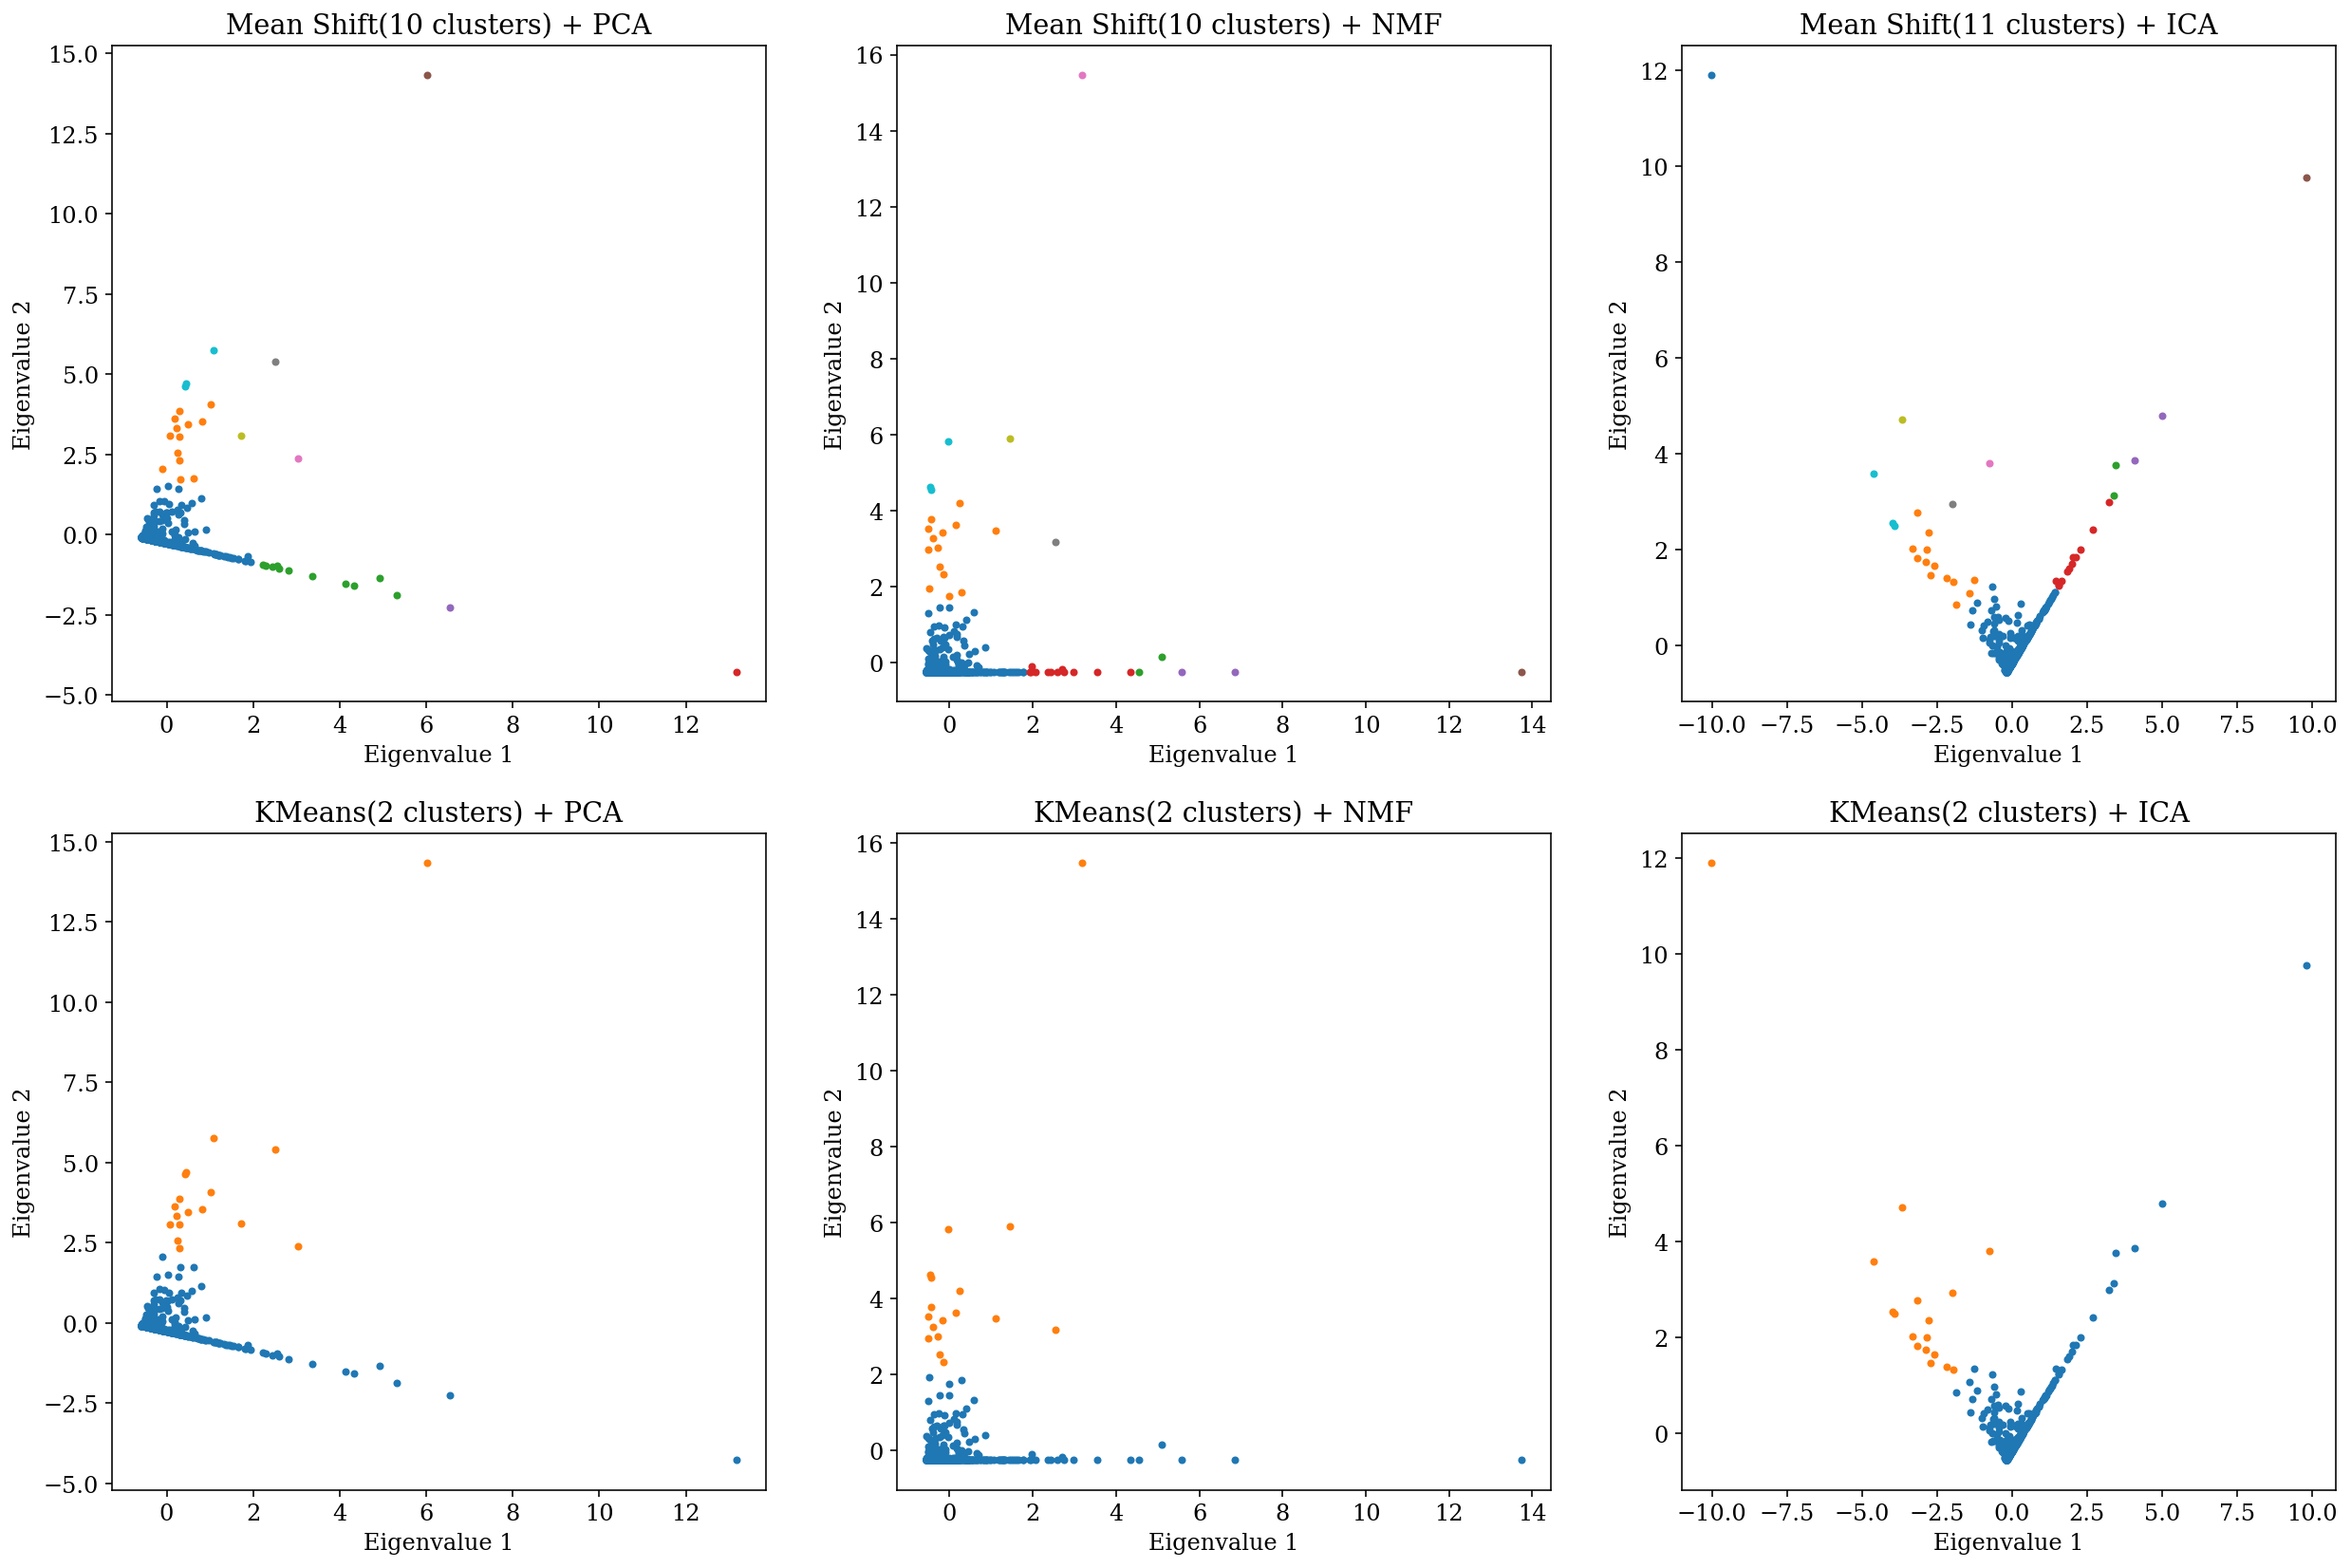

In [48]:
from sklearn.decomposition import PCA, NMF, FastICA
plt.figure(figsize=(21,14))

n_components = 2
n_clusters=2

pca = PCA(n_components=n_components)
nmf = NMF(n_components=n_components)
ica = FastICA(n_components=n_components)

clfs = [pca, nmf, ica]
labels = {
            pca: 'PCA',
            nmf: 'NMF',
            ica: 'ICA'
         }

for i, clf in enumerate(clfs):
    X_reduced = clf.fit_transform(data_raw)
    scaler = StandardScaler()
    X_reduced = scaler.fit_transform(X_reduced)
    #-- Kmeans
    km = KMeans(n_clusters=n_clusters)
    km.fit(X_reduced)
    labels_km = km.predict(X_reduced)
    
    #-- Mean shift
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
    ms.fit(X_reduced)
    labels_unique = np.unique(ms.labels_)
    n_clusters_ms = len(labels_unique[labels_unique >= 0])
    labels_ms = ms.predict(X_reduced)
    
    
    #--- plotting    
    ax = plt.subplot(231 + i) #Mean shift
    for j in range(n_clusters_ms):
        ax.scatter(X_reduced[:,0][labels_ms == j], X_reduced[:,1][labels_ms == j], marker='.')
    ax.set_title('Mean Shift(%.i clusters) + ' % n_clusters_ms + labels[clf])
    ax.set_xlabel('Eigenvalue 1')
    ax.set_ylabel('Eigenvalue 2')
    xaxis = ax.get_xlim()
    yaxis = ax.get_ylim()
    #---
    ax = plt.subplot(234 + i) #Kmeans
    for j in range(n_clusters):
        ax.scatter(X_reduced[:,0][labels_km == j], X_reduced[:,1][labels_km == j], marker='.')
    ax.set_title('KMeans(%.i clusters) + ' % n_clusters + labels[clf])
    #-- set the same limits on the axis
    ax.set_xlim(xaxis)
    ax.set_ylim(yaxis)
    #--
    ax.set_xlabel('Eigenvalue 1')
    ax.set_ylabel('Eigenvalue 2')
plt.show()

In [47]:
pca.explained_variance_ratio_

array([0.97063958, 0.02931306])

10/11 clusters? maybe outliers

plotting only the first 2: basically always the same result, but there are 3 points that the 2 clustering methods put in different classes